In [9]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical

# Load models and vectorizers
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('NBmodel.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('NBvectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')
data.dropna(subset=['cleaned_text'], inplace=True)

X = data['cleaned_text']
y = data['mental_health_issue']
y = label_encoder.transform(y)

# Split data into training and holdout sets (for blending)
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_holdout_one_hot = to_categorical(y_holdout, num_classes=len(label_encoder.classes_))

# Preprocess the text for the training set
X_train_lr = lr_vectorizer.transform(X_train)
X_train_svm = svm_vectorizer.transform(X_train)
X_train_nb = nb_vectorizer.transform(X_train)
X_train_xgb = tfidf_vectorizer.transform(X_train)
X_train_lstm = lstm_tokenizer.texts_to_sequences(X_train)
X_train_lstm = pad_sequences(X_train_lstm, maxlen=100, padding='post', truncating='post')

# Train base models
lr_model.fit(X_train_lr, y_train)
svm_model.fit(X_train_svm, y_train)
nb_model.fit(X_train_nb, y_train)
xgb_model.fit(X_train_xgb, y_train)

# Recompile the LSTM model to reset the optimizer
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the LSTM model with one-hot encoded labels
lstm_model.fit(X_train_lstm, y_train_one_hot, epochs=3, batch_size=32)  # Adjust epochs and batch size as needed

# Preprocess the text for the holdout set
X_holdout_lr = lr_vectorizer.transform(X_holdout)
X_holdout_svm = svm_vectorizer.transform(X_holdout)
X_holdout_nb = nb_vectorizer.transform(X_holdout)
X_holdout_xgb = tfidf_vectorizer.transform(X_holdout)
X_holdout_lstm = lstm_tokenizer.texts_to_sequences(X_holdout)
X_holdout_lstm = pad_sequences(X_holdout_lstm, maxlen=100, padding='post', truncating='post')

# Get predictions from base models on the holdout set
lr_predictions_proba = lr_model.predict_proba(X_holdout_lr)
svm_predictions_proba = svm_model.predict_proba(X_holdout_svm)
nb_predictions_proba = nb_model.predict_proba(X_holdout_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_holdout_xgb)
lstm_predictions_proba = lstm_model.predict(X_holdout_lstm)

# Stack the predictions to create the feature matrix for the meta-learner (blending)
stacked_features = np.hstack((
    lr_predictions_proba,
    svm_predictions_proba,
    nb_predictions_proba,
    xgb_predictions_proba,
    lstm_predictions_proba
))

# Train Random Forest as the meta-learner
meta_learner_rf = RandomForestClassifier(
    max_depth=None,
    min_samples_split=20,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=False,
    random_state=42
)

# Fit the meta-learner using the predictions from the base models (holdout set)
meta_learner_rf.fit(stacked_features, y_holdout)

# Save the trained Random Forest meta-learner
with open('meta_learner_rf_blending.pkl', 'wb') as file:
    pickle.dump(meta_learner_rf, file)

# Predict using the Random Forest meta-learner on the holdout set
final_predictions_rf = meta_learner_rf.predict(stacked_features)

# Evaluate the Random Forest blending model
accuracy_rf = accuracy_score(y_holdout, final_predictions_rf)
report_rf = classification_report(y_holdout, final_predictions_rf, target_names=label_encoder.classes_)

print(f"Random Forest Meta-Learner Accuracy (Blending): {accuracy_rf * 100:.2f}%")
print("Classification Report (Random Forest):\n", report_rf)
print("Confusion Matrix (Random Forest):\n", confusion_matrix(y_holdout, final_predictions_rf))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Epoch 1/3
465/465 ━━━━━━━━━━━━━━━━━━━━ 73s 152ms/step - accuracy: 0.8681 - loss: 0.3894
Epoch 2/3
465/465 ━━━━━━━━━━━━━━━━━━━━ 72s 154ms/step - accuracy: 0.9087 - loss: 0.2800
Epoch 3/3
465/465 ━━━━━━━━━━━━━━━━━━━━ 70s 150ms/step - accuracy: 0.9284 - loss: 0.2256
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step
Random Forest Meta-Learner Accuracy (Blending): 97.82%
Classification Report (Random Forest):
               precision    recall  f1-score   support

     anxiety       0.97      0.97      0.97       379
     bipolar       0.96      0.91      0.94       384
  depression       0.93      0.96      0.94       373
      normal       0.99      1.00      0.99      2183
        ptsd       0.97      0.97      0.97       394

    accuracy                           0.98      3713
   macro avg       0.96      0.96      0.96      3713
weighted avg       0.98      0.98      0.98      3713

Confusion Matrix (Random Forest):
 [[ 366    2    6    1    4]
 [   2  351   15   14    2]
 [   6    3  357   

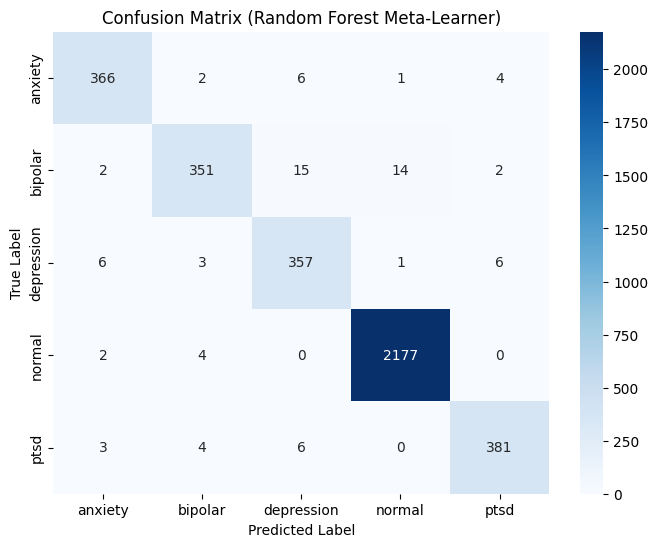

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_holdout, final_predictions_rf)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (Random Forest Meta-Learner)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


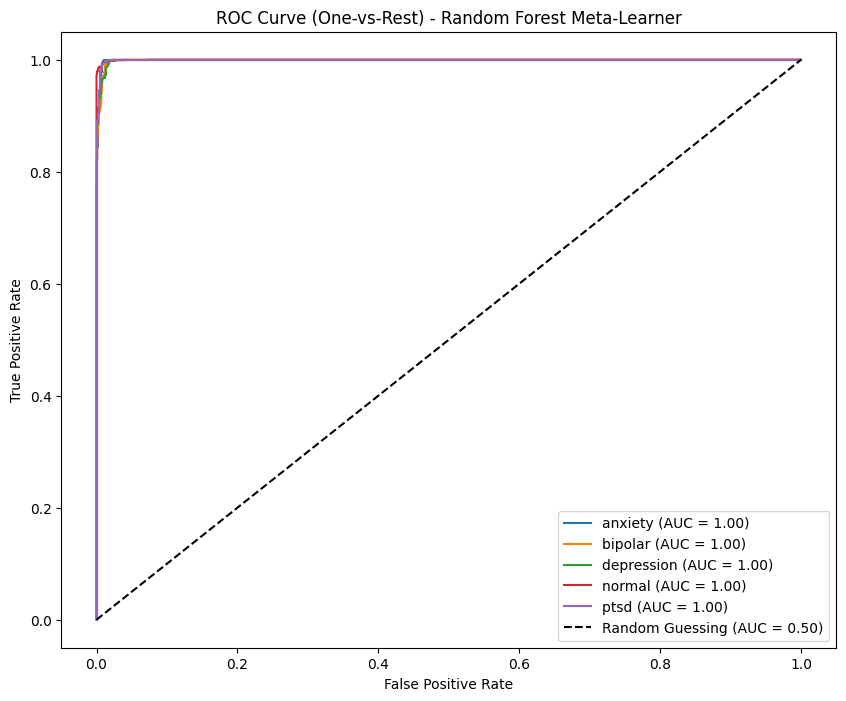

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC AUC (One-vs-Rest approach)
y_bin = label_binarize(y_holdout, classes=np.arange(len(label_encoder.classes_)))

# Get the predicted probabilities for each class
y_probs_rf = meta_learner_rf.predict_proba(stacked_features)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(len(label_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_probs_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

# Plot diagonal line (no skill)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)')

plt.title('ROC Curve (One-vs-Rest) - Random Forest Meta-Learner')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
